In [1]:
import pandas as pd
from keras import models, layers, optimizers, regularizers
import numpy as np
import random
from sklearn import model_selection, preprocessing
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

Using TensorFlow backend.


## load the data

In [2]:
file_name = 'stock.csv'
data = pd.read_csv(file_name,encoding = "ISO-8859-1")

In [3]:
data.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume
0,2-Jan-09,902.99,931.80,934.73,899.35,4048270080
1,5-Jan-09,929.17,927.45,936.63,919.53,5413910016
2,6-Jan-09,931.17,934.70,943.85,927.28,5392620032
3,7-Jan-09,927.45,906.65,927.45,902.37,4704940032
4,8-Jan-09,905.73,909.73,910.00,896.81,4991549952


## prepare the data

,Date,Open Price,Close Price,High Price,Low Price,Volume,log_change
0,2-Jan-09,902.99,931.80,934.73,899.35,4048270080,NaN
1,5-Jan-09,929.17,927.45,936.63,919.53,5413910016,-0.004679
2,6-Jan-09,931.17,934.70,943.85,927.28,5392620032,0.007787
3,7-Jan-09,927.45,906.65,927.45,902.37,4704940032,-0.030469
4,8-Jan-09,905.73,909.73,910.00,896.81,4991549952,0.003391


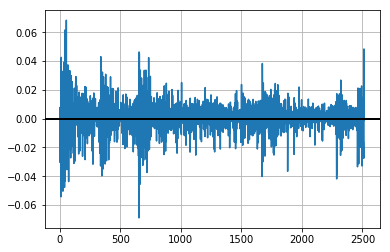

In [4]:
close = data['Close Price']
data['log_change'] = np.log(close) - np.log(close.shift(1))
data.log_change.plot(grid=True).axhline(y=0, color='black', lw=2)
data.head()

In [5]:
def mapping(x):
    if x>0:
        return 1
    else:
        return 0
data['price_change']=data['log_change'].apply(mapping)
data.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume,log_change,price_change
0,2-Jan-09,902.99,931.80,934.73,899.35,4048270080,NaN,0
1,5-Jan-09,929.17,927.45,936.63,919.53,5413910016,-0.004679,0
2,6-Jan-09,931.17,934.70,943.85,927.28,5392620032,0.007787,1
3,7-Jan-09,927.45,906.65,927.45,902.37,4704940032,-0.030469,0
4,8-Jan-09,905.73,909.73,910.00,896.81,4991549952,0.003391,1


### 轉換成datetime

In [6]:
data['Date']=pd.to_datetime(data['Date'])
print(data.dtypes)

Date            datetime64[ns]
Open Price             float64
Close Price            float64
High Price             float64
Low Price              float64
Volume                   int64
log_change             float64
price_change             int64
dtype: object


### 將index轉為時間

In [7]:
data=data.set_index(data['Date'],drop=True)
del data['Date']
data.head()

,Open Price,Close Price,High Price,Low Price,Volume,log_change,price_change
Date,,,,,,,
2009-01-02,902.99,931.80,934.73,899.35,4048270080,NaN,0
2009-01-05,929.17,927.45,936.63,919.53,5413910016,-0.004679,0
2009-01-06,931.17,934.70,943.85,927.28,5392620032,0.007787,1
2009-01-07,927.45,906.65,927.45,902.37,4704940032,-0.030469,0
2009-01-08,905.73,909.73,910.00,896.81,4991549952,0.003391,1


In [8]:
data.index=pd.to_datetime(data.index,format='%Y-%m-%d')#將index轉為時間datetime
data.head()

,Open Price,Close Price,High Price,Low Price,Volume,log_change,price_change
Date,,,,,,,
2009-01-02,902.99,931.80,934.73,899.35,4048270080,NaN,0
2009-01-05,929.17,927.45,936.63,919.53,5413910016,-0.004679,0
2009-01-06,931.17,934.70,943.85,927.28,5392620032,0.007787,1
2009-01-07,927.45,906.65,927.45,902.37,4704940032,-0.030469,0
2009-01-08,905.73,909.73,910.00,896.81,4991549952,0.003391,1


### create two new variables, train and test including the correct data points. 

In [9]:
train = data[data.index.year<=2017].drop(columns=['log_change'])
test = data[data.index.year>2017].drop(columns=['log_change'])

In [10]:
x_train = train.loc[:,train.columns !='price_change']
y_train = train['price_change']
x_test = test.loc[:,test.columns !='price_change']
y_test = test['price_change']

### normalize the data

In [11]:
x_train = preprocessing.normalize(x_train)
x_test = preprocessing.normalize(x_test)

In [12]:
x_test

array([[1.45344351e-06, 1.45998575e-06, 1.46002907e-06, 1.45270155e-06,
        1.00000000e+00],
       [1.29046974e-06, 1.29774518e-06, 1.29837179e-06, 1.29043147e-06,
        1.00000000e+00],
       [1.29443629e-06, 1.29666404e-06, 1.29918693e-06, 1.29432204e-06,
        1.00000000e+00],
       ...,
       [1.02347978e-06, 1.04289342e-06, 1.04300656e-06, 1.00480782e-06,
        1.00000000e+00],
       [1.20091219e-06, 1.19464995e-06, 1.21124512e-06, 1.18847423e-06,
        1.00000000e+00],
       [1.30651228e-06, 1.31064784e-06, 1.31189740e-06, 1.29808432e-06,
        1.00000000e+00]])

### setting the parameters

In [13]:
hidden_units = 10    # how many neurons in the hidden layer
activation = 'relu'  # activation function for hidden layer
l2 = 0.001           # regularization - how much we penalize large parameter values
learning_rate = 0.1  # how big our steps are in gradient descent
epochs = 20          # how many epochs to train for
batch_size = 32      # how many samples to use for each gradient descent update

### build the modal

In [14]:
# create a sequential model
model = models.Sequential()

# add the hidden layer
model.add(layers.Dense(input_dim=5,
                       units=hidden_units, 
                       activation=activation))

# add the output layer
model.add(layers.Dense(input_dim=hidden_units,
                       units=1,
                       activation='sigmoid'))

# define our loss function and optimizer
model.compile(loss='binary_crossentropy',
              # Adam is a kind of gradient descent
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


### train the model

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
2264/2264 [==============================] - ETA: 2:08 - loss: 0.7646 - acc: 0.375 - ETA: 3s - loss: 0.6965 - acc: 0.5557  - 2s 858us/step - loss: 0.6934 - acc: 0.5336
Epoch 2/10
2264/2264 [==============================] - ETA: 0s - loss: 0.6380 - acc: 0.718 - ETA: 0s - loss: 0.6933 - acc: 0.545 - 0s 43us/step - loss: 0.6930 - acc: 0.5459
Epoch 3/10
2264/2264 [==============================] - ETA: 0s - loss: 0.7058 - acc: 0.500 - ETA: 0s - loss: 0.6949 - acc: 0.520 - 0s 36us/step - loss: 0.6937 - acc: 0.5256
Epoch 4/10
2264/2264 [==============================] - ETA: 0s - loss: 0.6683 - acc: 0.656 - ETA: 0s - loss: 0.6941 - acc: 0.524 - 0s 44us/step - loss: 0.6922 - acc: 0.5336
Epoch 5/10
2264/2264 [==============================] - ETA: 0s - loss: 0.6777 - acc: 0.593 - ETA: 0s - loss: 0.6956 - acc: 0.500 - 0s 36us/step - loss: 0.6909 - acc: 0.5256
Epoch 6/10
2264/2264 [==============================] - ETA: 0s - loss: 0.675

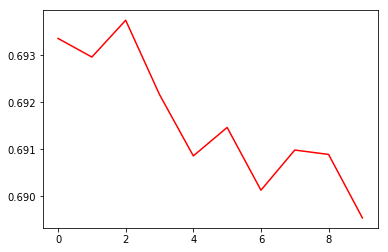

In [15]:
# train the parameters
history = model.fit(x_train, y_train, epochs=10, batch_size=batch_size)

# evaluate accuracy
train_acc = model.evaluate(x_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(x_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()

The initial parameters of the network will be randomly determined. We will start on a random part of the loss surface each time. This will lead to a different result.
This is actually a research probelm at the moment. So what can we do if we want a fair competition? We will train our network 20 times and take the average.

###  take the average accuracy

In [16]:
def train_and_evaluate(model, x_train, y_train, x_test, y_test, n=20):
    train_accs = []
    test_accs = []
    with tqdm(total=n) as progress_bar:
        for _ in range(n):
            model.fit(
                x_train, 
                y_train, 
                epochs=epochs, 
                batch_size=batch_size,  
                verbose=False)
            train_accs.append(model.evaluate(x_train, y_train, batch_size=32, verbose=False)[1])
            test_accs.append(model.evaluate(x_test, y_test, batch_size=32, verbose=False)[1])
            progress_bar.update()
    print('Avgerage Training Accuracy: %s' % np.average(train_accs))
    print('Avgerage Testing Accuracy: %s' % np.average(test_accs))
    return train_accs, test_accs

In [17]:
_, test_accs = train_and_evaluate(model, x_train, y_train, x_test, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.00it/s]


Avgerage Training Accuracy: 0.5413427562943195
Avgerage Testing Accuracy: 0.5214285720198873


### violin plot

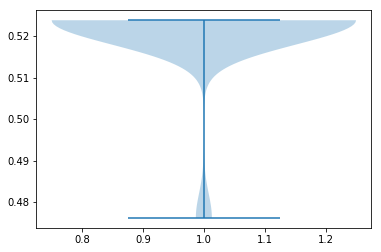

In [18]:
plt.violinplot(test_accs)
plt.show()

we can get the avgerage testing accuracy 52.1%

## drop Volume

In [19]:
x_train = train.loc[:,train.columns !='price_change']
y_train = train['price_change']
x_test = test.loc[:,test.columns !='price_change']
y_test = test['price_change']

In [20]:
x_train = x_train.drop(['Volume'], axis=1)
x_test = x_test.drop(['Volume'], axis=1)

### normalize the data

In [21]:
x_train = preprocessing.normalize(x_train)
x_test = preprocessing.normalize(x_test)

### setting the parameters

In [22]:
hidden_units = 10    # how many neurons in the hidden layer
activation = 'relu'  # activation function for hidden layer
l2 = 0.001           # regularization - how much we penalize large parameter values
learning_rate = 0.1  # how big our steps are in gradient descent
epochs = 20          # how many epochs to train for
batch_size = 32      # how many samples to use for each gradient descent update

### build the modal

In [23]:
# create a sequential model
model = models.Sequential()

# add the hidden layer
model.add(layers.Dense(input_dim=4,
                       units=hidden_units, 
                       activation=activation))

# add the output layer
model.add(layers.Dense(input_dim=hidden_units,
                       units=1,
                       activation='sigmoid'))

# define our loss function and optimizer
model.compile(loss='binary_crossentropy',
              # Adam is a kind of gradient descent
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

### train the model

Epoch 1/10
2264/2264 [==============================] - ETA: 16s - loss: 0.7192 - acc: 0.46 - ETA: 0s - loss: 0.7078 - acc: 0.4953 - 0s 151us/step - loss: 0.7018 - acc: 0.5053
Epoch 2/10
2264/2264 [==============================] - ETA: 0s - loss: 0.6858 - acc: 0.562 - ETA: 0s - loss: 0.6910 - acc: 0.541 - 0s 43us/step - loss: 0.6901 - acc: 0.5459
Epoch 3/10
2264/2264 [==============================] - ETA: 0s - loss: 0.6615 - acc: 0.656 - ETA: 0s - loss: 0.6880 - acc: 0.558 - 0s 34us/step - loss: 0.6910 - acc: 0.5459
Epoch 4/10
2264/2264 [==============================] - ETA: 0s - loss: 0.6912 - acc: 0.531 - ETA: 0s - loss: 0.6906 - acc: 0.531 - 0s 39us/step - loss: 0.6903 - acc: 0.5353
Epoch 5/10
2264/2264 [==============================] - ETA: 0s - loss: 0.7065 - acc: 0.437 - ETA: 0s - loss: 0.6924 - acc: 0.543 - 0s 39us/step - loss: 0.6938 - acc: 0.5283
Epoch 6/10
2264/2264 [==============================] - ETA: 0s - loss: 0.6617 - acc: 0.656 - ETA: 0s - loss: 0.6895 - acc: 0.55

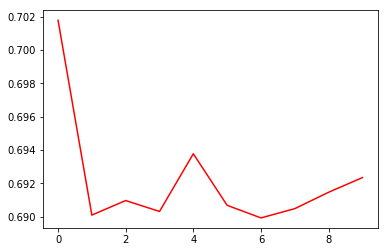

In [24]:
# train the parameters
history = model.fit(x_train, y_train, epochs=10, batch_size=batch_size)

# evaluate accuracy
train_acc = model.evaluate(x_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(x_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()

### take the average accuracy

In [25]:
_, test_accs = train_and_evaluate(model, x_train, y_train, x_test, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.03s/it]


Avgerage Training Accuracy: 0.5367491167236131
Avgerage Testing Accuracy: 0.5190476197571982


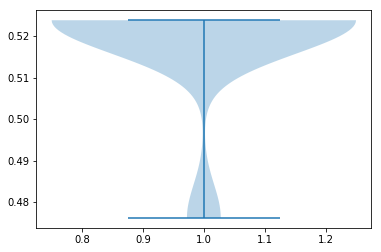

In [26]:
plt.violinplot(test_accs)
plt.show()